# Identifying Tire Locations in Images of Cars

###Installing and Importing Packages

In [ ]:
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade

In [ ]:
import fastai
import fastcore
import pandas as pd
import json
print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

Fast.ai version: 2.3.0
Fastcore version: 1.3.19


In [ ]:
from fastai.vision.all import *

In [ ]:
!nvidia-smi

Thu Apr  8 12:47:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Preparing the dataset

#### Importing images from the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Deep Learning/'

/content/drive/MyDrive/Deep Learning


In [ ]:
path = Path('cars')

In [ ]:
path

Path('cars')

In [ ]:
Path.BASE_PATH = path

In [ ]:
img_files = get_image_files(path)

In [ ]:
img_files[0]

Path('93_toyota_camry_2009_2018_6.jpg')

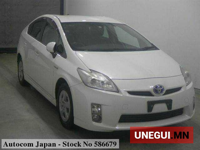

In [ ]:
im = PILImage.create(img_files[42])
im.shape
im.to_thumb(200)

#### Preparing the train dataset

In [ ]:
df = pd.read_json('unegui_car_labels.json')
df.dtypes

ID                      object
DataRow ID              object
Labeled Data            object
Label                   object
Created By              object
Project Name            object
Created At              object
Updated At              object
Seconds to Label       float64
External ID             object
Agreement              float64
Benchmark Agreement      int64
Benchmark ID           float64
Dataset Name            object
Reviews                 object
View Label              object
Has Open Issues          int64
dtype: object

In [ ]:
tire = pd.DataFrame(columns = ['fname', 'x', 'y'])
tire

,fname,x,y


In [ ]:
for i,r in df.iterrows():
  label_json = r['Label']
  image_name = r['External ID']
  if 'objects' not in label_json.keys():
    continue

  for json in label_json['objects']:
    if json['title'] == 'Tire':
      points = tensor([int(json['point']['x']),
                      int(json['point']['y'])])
      x = points.numpy()[0]
      y = points.numpy()[1]
      
      tire = tire.append({'fname': image_name,
                            'x': x,
                            'y':y},
                            ignore_index=True)

####  Splitting data into train and test for ColSplitter

In [ ]:
msk = np.random.rand(len(tire)) < 0.8

In [ ]:
df_train = tire[msk]
df_valid = tire[~msk]

In [ ]:
df_train.shape

(6560, 3)

In [ ]:
df_valid.shape

(1624, 3)

In [ ]:
df_train['is_valid'] = False
df_valid['is_valid'] = True
tire = pd.concat([df_train, df_valid], axis=0).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
tire

,fname,x,y,is_valid
0,5_mitsubishi_delica_2005_2015_2.jpg,386,352,False
1,5_mitsubishi_delica_2005_2015_2.jpg,121,347,False
2,2_toyota_aqua_2014_2021_2.jpg,243,312,False
3,2_toyota_aqua_2014_2021_2.jpg,129,186,False
4,5_porsche_cayenne_2015_2016_4.jpg,467,276,False
...,...,...,...,...
8179,11_toyota_camry_2012_2021_6.jpg,482,194,True
8180,18_lexus_rx_2012_2021_7.jpg,322,647,True
8181,18_lexus_rx_2012_2021_7.jpg,578,462,True
8182,17_toyota_prius_20_2004_2014_4.jpg,52,259,True


### Building DataLoaders

In [ ]:
def get_x(r):
  fname = str(r['fname'])
  return '/content/drive/MyDrive/Deep Learning/cars/' + fname

def get_y(r):
  return tensor([r['x'],r['y']])

In [ ]:
dblock = DataBlock(blocks = (ImageBlock, PointBlock),
                   splitter = ColSplitter(),
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = Resize((600,600), method='pad'))
dls = dblock.dataloaders(tire, batch_size = 16)

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([16, 3, 600, 600]), torch.Size([16, 1, 2]))

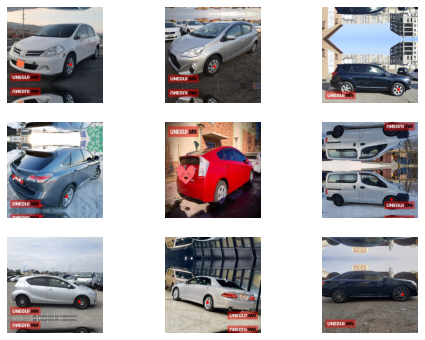

In [ ]:
dls.show_batch(max_n=9, figsize=(8,6))

### Fine Tuning

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

In [ ]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,time
0,0.392372,0.282597,08:35


epoch,train_loss,valid_loss,time
0,0.211860,0.170717,03:06
1,0.160150,0.142197,03:06
2,0.153086,0.134101,03:06
3,0.126268,0.133245,03:05
4,0.123707,0.132800,03:05


In [ ]:
RMSE = np.sqrt(0.132800)
print('RMSE is', RMSE)

RMSE is 0.36441734316577196


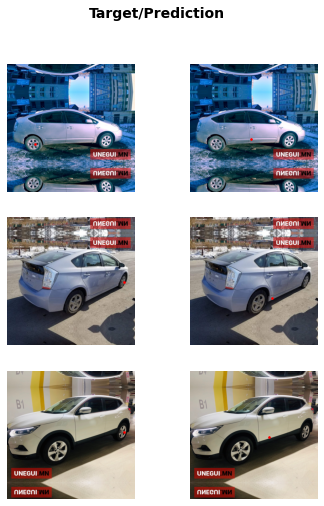

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

### Option #2

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
tire = tire.drop(columns = ['is_valid'])
tire.head()

,fname,x,y
0,20_toyota_aqua_2013_2021_1.jpg,237,326
1,3_toyota_harrier_2005_2020_3.jpg,66,81
2,3_mitsubishi_delica_2008_2014_1.jpg,358,339
3,2_subaru_forester_2012_2021_2.jpg,512,253
4,2_toyota_harrier_2014_2021_3.jpg,535,218


In [ ]:
train, test = train_test_split(tire, test_size=0.2)

In [ ]:
train.shape

(6547, 3)

In [ ]:
test.shape

(1637, 3)

In [ ]:
train['is_valid'] = False
test['is_valid'] = True
tire_1 = pd.concat([train, test], axis=0).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
tire_1

,fname,x,y,is_valid
0,21_toyota_crown_2011_2021_6.jpg,61,215,False
1,19_toyota_sai_2014_2021_1.jpg,342,184,False
2,19_toyota_prius_20_2006_2017_2.jpg,281,311,False
3,6_toyota_harrier_2012_2021_3.jpg,464,299,False
4,6_lexus_rx_2014_2021_1.jpg,527,241,False
...,...,...,...,...
8179,3_toyota_fielder_2014_2021_2.jpg,111,377,True
8180,14_suzuki_jimny_2008_2016_6.jpg,169,87,True
8181,21_toyota_passo_2009_2018_0.jpg,518,313,True
8182,22_nissan_sunny_1999_2008_0.jpg,335,564,True


In [ ]:
dblock1 = DataBlock(blocks = (ImageBlock, PointBlock),
                   splitter = ColSplitter(),
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = Resize((600,600), method='pad'))
dls1 = dblock.dataloaders(tire_1, batch_size = 16)

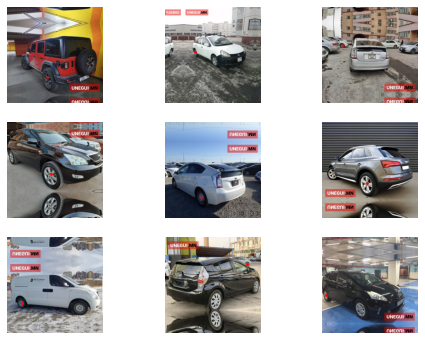

In [ ]:
dls1.show_batch(max_n=9, figsize=(8,6))

In [ ]:
learn1 = cnn_learner(dls1, resnet18, y_range=(-1,1))

In [ ]:
dls1.loss_func

FlattenedLoss of MSELoss()

In [ ]:
learn1.fine_tune(5)

epoch,train_loss,valid_loss,time
0,0.405098,0.255905,02:43


epoch,train_loss,valid_loss,time
0,0.203736,0.169419,03:03
1,0.166167,0.138962,03:03
2,0.150192,0.132925,03:03
3,0.134305,0.129886,03:03
4,0.123120,0.131700,03:03


In [ ]:
RMSE1 = np.sqrt(0.131700)
print('RMSE #2 is',RMSE1)

RMSE #2 is 0.3629049462324811


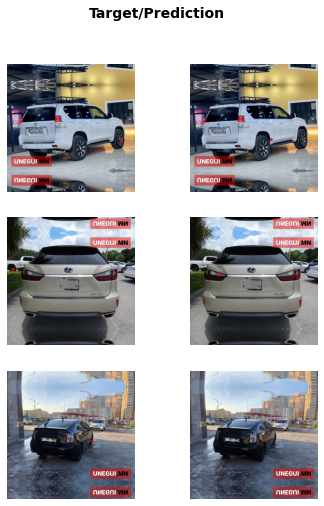

In [ ]:
learn1.show_results(ds_idx=1, nrows=3, figsize=(6,8))

We can see that there are multiple locations are given. But my model gives only one for each image. 

In [ ]:
tire_1[tire_1['fname'] == '4_toyota_prius_40_41_2015_2021_2.jpg']

,fname,x,y,is_valid
1822,4_toyota_prius_40_41_2015_2021_2.jpg,64,215,False
3005,4_toyota_prius_40_41_2015_2021_2.jpg,214,291,False
3917,4_toyota_prius_40_41_2015_2021_2.jpg,72,217,False
5072,4_toyota_prius_40_41_2015_2021_2.jpg,207,268,False
6542,4_toyota_prius_40_41_2015_2021_2.jpg,224,297,False
8182,4_toyota_prius_40_41_2015_2021_2.jpg,67,220,True
